### Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from neuropy import plotting
import subjects

### Create radon dataframe

In [65]:
sessions = subjects.pf_sess()
# sessions = subjects.nsd.pf_sess
radon_df = []
for sub, sess in enumerate(sessions):

    neurons = sess.neurons_stable.get_neuron_type(["pyr",'mua'])
    neurons = neurons[neurons.firing_rate <= 10]

    replay_pbe = sess.replay_radon_mua.to_dataframe()
    pbe_filter = sess.pbe_filters.to_dataframe()

    # good_bool = pbe_filter.is_rpl & pbe_filter.is_5units & pbe_filter.is_rest
    # replay_pbe = replay_pbe[good_bool]
    starts = replay_pbe.start.values

    up_score = replay_pbe.up_score.values
    up_vel = replay_pbe.up_velocity.values
    down_score = replay_pbe.down_score.values
    down_vel = -replay_pbe.down_velocity.values

    best_bool = up_score > down_score
    score = np.zeros(len(starts))
    score[best_bool] = up_score[best_bool]
    score[~best_bool] = down_score[~best_bool]
    # score = min_max_scaler(score)

    vel = np.zeros(len(starts))
    vel[best_bool] = up_vel[best_bool]
    vel[~best_bool] = down_vel[~best_bool]

    epochs = sess.get_zt_epochs(include_maze=True)
    starts_bool, _, starts_labels = epochs.contains(starts)

    df = pd.DataFrame(
        dict(
            zt=starts_labels,
            score=score[starts_bool],
            speed=np.abs(vel)[starts_bool],
            n_neurons=neurons.n_neurons,
            method="radon",
            session=sub,
            name=sess.animal.name + sess.animal.day,
            grp=sess.tag,
        )
    )

    score_pre, score_maze = [
        (f := df.groupby("zt")).get_group("PRE").score.values,
        f.get_group("MAZE").score.values,
    ]

    perc_rel_pre = [
        stats.percentileofscore(score_pre, _, kind="strict") for _ in df.score
    ]

    df["score_rel_pre"] = df.score / score_pre.mean()
    df["score_rel_maze"] = df.score / score_maze.mean()
    df["perc_rel_pre"] = perc_rel_pre

    radon_df.append(df)

radon_df = pd.concat(radon_df, ignore_index=True)
subjects.GroupData().save(radon_df, "replay_radon_mua")


#Sessions = 13
replay_radon_mua saved


### Radon score distribution individual sessions

In [ ]:
fig = plotting.Fig(grid=(9,5),width_ratios=[2,4,2,4,1])

for g,grp in enumerate(['NSD','SD']):
    grp_df = radon_df[radon_df.grp==grp]
    sessions_id = grp_df.session.unique()

    for s,sess in enumerate(sessions_id):

        sess_df =  grp_df[grp_df.session==sess]
        name = sess_df.name.unique()[0]

        ax = fig.subplot(fig.gs[s,2*g+1])
        plot_kw = dict(data=sess_df,x='zt',y='score')
        sns.violinplot(**plot_kw,color=subjects.colors_sd()[g],ax=ax,inner=None)
        sns.pointplot(**plot_kw,ci=None,color='w',join=False,scale=0.5)
        # ax.axhline(1,color='#2fd077')
        # ax.set_ylim(0.1,3)
        ax.set_ylim(0,1.3)
        ax.set_xlabel('')
        ax.set_title(name,loc='left')

        ax = fig.subplot(fig.gs[s,2*g])
        sess_ = sessions[sess]
        maze =  sess_.paradigm['maze'].flatten()
        position = sess_.position.time_slice(*maze)
        ax.plot(position.x,position.y,color='#1cca56')
        ax.axis('off')

# fig.savefig(subjects.figpath_sd/'radon_dist.pdf')

### Radon scores pooled across sessions

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MAZE_NSD vs. MAZE_SD: Kruskal-Wallis independent samples (pairwise between groups), P_val:1.159e-137 Stat=6.237e+02
PRE_NSD vs. PRE_SD: Kruskal-Wallis independent samples (pairwise between groups), P_val:0.000e+00 Stat=3.505e+03
0-2.5_NSD vs. 0-2.5_SD: Kruskal-Wallis independent samples (pairwise between groups), P_val:0.000e+00 Stat=2.679e+03
2.5-5_NSD vs. 2.5-5_SD: Kruskal-Wallis independent samples (pairwise between groups), P_val:7.347e-128 Stat=5.787e+02
5-7.5_NSD vs. 5-7.5_SD: Kruskal-Wallis independent samples (pairwise between groups), P_val:4.005e-133 Stat=6.029e+02


<AxesSubplot:xlabel='zt', ylabel='score'>

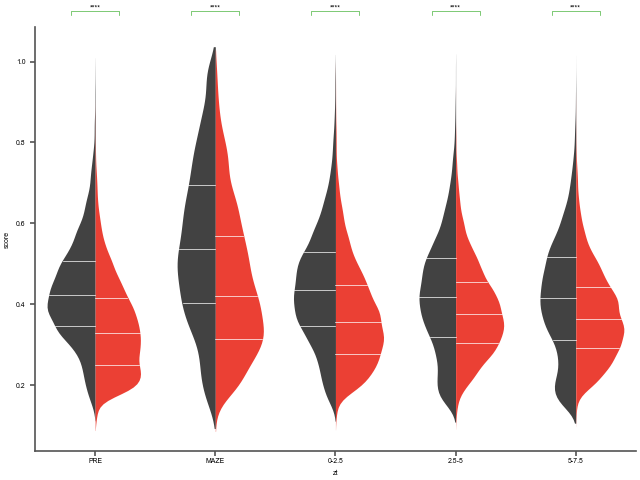

In [68]:
from plotters import violinplot
# fig = plotting.Fig(grid=(2, 2))
# ax = fig.subplot(fig.gs[0])


df = []
for g,grp in enumerate(['NSD','SD']):
    grp_df= radon_df.groupby('grp').get_group(grp)
    mean_pre = grp_df.groupby(['zt']).mean().score['PRE']
    grp_df = grp_df.assign(score=grp_df['score']/mean_pre)
    df.append(grp_df)

df = pd.concat(df,ignore_index=True)

_,ax = plt.subplots()
violinplot(data=radon_df, x="zt", y="score",stat_anot=True)

# sns.violinplot(data=radon_df, x="zt", y="score",hue='grp',split=True)
# sns.violinplot(data=radon_df, x="zt", y="score",hue='grp',showfliers=False)

### Radon score vs speed NSD vs SD

In [ ]:
_,ax = plt.subplots()

sns.violinplot(data=radon_df,x='zt',y='score',hue='grp',split=True)

In [ ]:
_,axs = plt.subplots(2,5,sharex=True,sharey=True)
radon_df = radon_df[np.abs(radon_df.vel)<5000]
zts = radon_df.zt.unique()
for i,zt in enumerate(zts):
    for g,grp in enumerate(['NSD','SD']):
        df = radon_df[(radon_df.zt==zt)&(radon_df.grp==grp)]
        axs[g,i].scatter(df.vel,df.score,s=2)
        axs[g,i].axvline(-100)
        axs[g,i].axvline(100)
        axs[g,i].set_xscale('log')